In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Importing relevant Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
import requests
import io
import random
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import timeit
from tensorflow.keras.callbacks import EarlyStopping
from fbprophet import Prophet

Reading the data

In [4]:
df = pd.read_csv('time_series_covid19_deaths_global.csv')

In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,14,15,15,18,18,21,23,25,30,30
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,22,23,23,23,23,23,24,25,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,205,235,256,275,293,313,326,336,348,364
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,23,25,26,26,29,29,31,33,33,35
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [6]:
df_canada = df.loc[df['Country/Region']=='Canada'].iloc[:,4:]

In [7]:
df_canada.shape

(15, 87)

In [8]:
df_canada.isnull().sum()

1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
          ..
4/13/20    0
4/14/20    0
4/15/20    0
4/16/20    0
4/17/20    0
Length: 87, dtype: int64

In [9]:
death_daily = df_canada.sum(axis = 0)

In [10]:
death_daily.head(-15)

1/22/20      0
1/23/20      0
1/24/20      0
1/25/20      0
1/26/20      0
          ... 
3/29/20     64
3/30/20     80
3/31/20    101
4/1/20     109
4/2/20     139
Length: 72, dtype: int64

In [11]:
death_daily.index=pd.to_datetime(death_daily.index)
death_daily.head()

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

/Users/mokul791/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Daily Death in Canada')

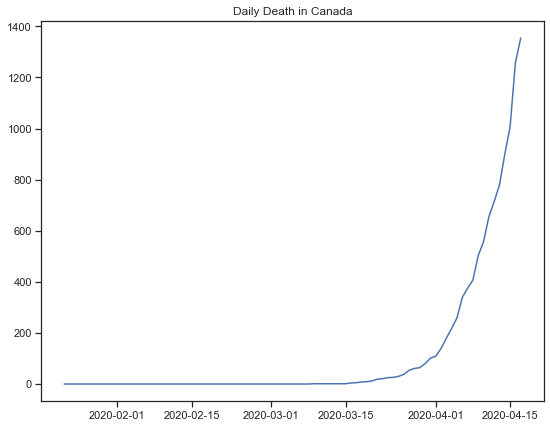

In [12]:
plt.figure(figsize=(9,7))
plt.plot(death_daily)
plt.title("Daily Death in Canada")

In [13]:
death_ca = death_daily.diff().fillna(death_daily[0]).astype(np.int)

In [14]:
death_ca.head(-5)

2020-01-22     0
2020-01-23     0
2020-01-24     0
2020-01-25     0
2020-01-26     0
              ..
2020-04-08    32
2020-04-09    96
2020-04-10    54
2020-04-11    97
2020-04-12    60
Length: 82, dtype: int64

Text(0.5, 1.0, 'Daily Death')

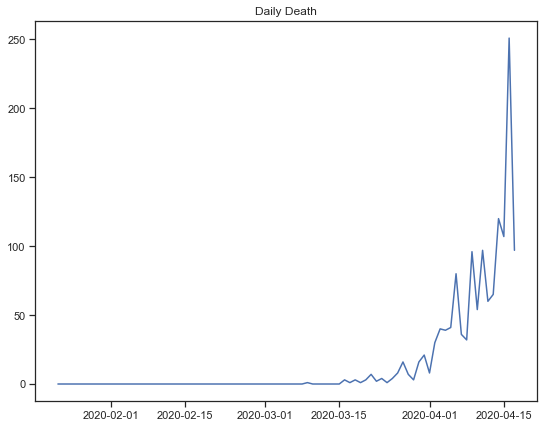

In [15]:
plt.figure(figsize=(9,7))
plt.plot(death_ca)
plt.title("Daily Death")

In [16]:
death_ca=pd.DataFrame(death_ca)
death_ca.index.name = 'Datetime'
death_ca
col=['Daily_death']
death_ca.columns=col
death_ca

,Daily_death
Datetime,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-04-13,65
2020-04-14,120
2020-04-15,107


In [17]:
death_ca.shape

(87, 1)

In [18]:
split_date = '2020-04-05'
train = death_ca.loc[death_ca.index <= split_date].copy()
test = death_ca.loc[death_ca.index > split_date].copy()

In [19]:
train.shape, test.shape

((75, 1), (12, 1))

In [20]:
test

,Daily_death
Datetime,
2020-04-06,80
2020-04-07,36
2020-04-08,32
2020-04-09,96
2020-04-10,54
2020-04-11,97
2020-04-12,60
2020-04-13,65
2020-04-14,120


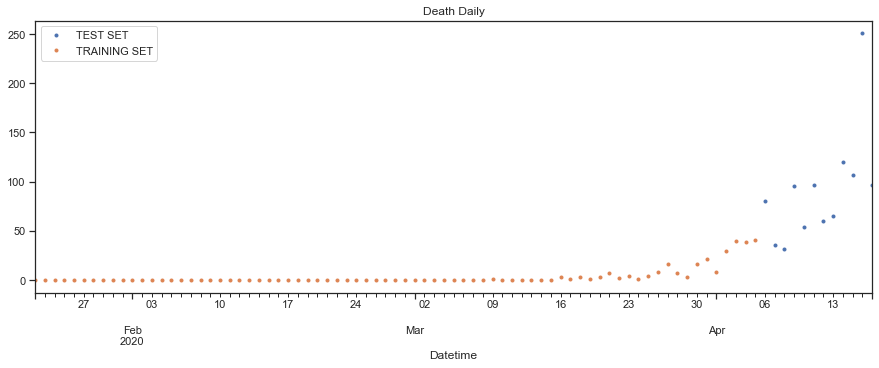

In [21]:
test \
    .rename(columns={'Daily_death': 'TEST SET'}) \
    .join(train.rename(columns={'Daily_death': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Death Daily', style='.')
plt.show()

In [38]:
# Format data for prophet model using ds and y
train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Daily_death':'y'}).head()

,ds,y
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [40]:

# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'Daily_death':'y'}))

In [46]:
test_forcast = model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [47]:
test_forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-04-06,13.401512,3.598138,20.983021,13.401373,13.401783,-0.852636,-0.852636,-0.852636,-0.852636,-0.852636,-0.852636,0.0,0.0,0.0,12.548876
1,2020-04-07,13.695807,3.383233,21.250276,13.692385,13.698710,-1.194464,-1.194464,-1.194464,-1.194464,-1.194464,-1.194464,0.0,0.0,0.0,12.501343
2,2020-04-08,13.990103,3.400698,21.297519,13.982284,13.998440,-1.602460,-1.602460,-1.602460,-1.602460,-1.602460,-1.602460,0.0,0.0,0.0,12.387643
3,2020-04-09,14.284398,6.293475,23.644565,14.271732,14.298886,0.340635,0.340635,0.340635,0.340635,0.340635,0.340635,0.0,0.0,0.0,14.625033
4,2020-04-10,14.578694,8.082572,24.807231,14.560607,14.601182,1.920063,1.920063,1.920063,1.920063,1.920063,1.920063,0.0,0.0,0.0,16.498757
5,2020-04-11,14.872989,7.183219,24.892670,14.847421,14.903020,1.135874,1.135874,1.135874,1.135874,1.135874,1.135874,0.0,0.0,0.0,16.008863
6,2020-04-12,15.167284,6.455510,24.769835,15.134314,15.204886,0.252988,0.252988,0.252988,0.252988,0.252988,0.252988,0.0,0.0,0.0,15.420273
7,2020-04-13,15.461580,5.252026,23.299975,15.420311,15.508312,-0.852636,-0.852636,-0.852636,-0.852636,-0.852636,-0.852636,0.0,0.0,0.0,14.608944
8,2020-04-14,15.755875,5.764728,22.876835,15.705589,15.812905,-1.194464,-1.194464,-1.194464,-1.194464,-1.194464,-1.194464,0.0,0.0,0.0,14.561411
9,2020-04-15,16.050170,5.088190,22.770631,15.991752,16.115423,-1.602460,-1.602460,-1.602460,-1.602460,-1.602460,-1.602460,0.0,0.0,0.0,14.447711


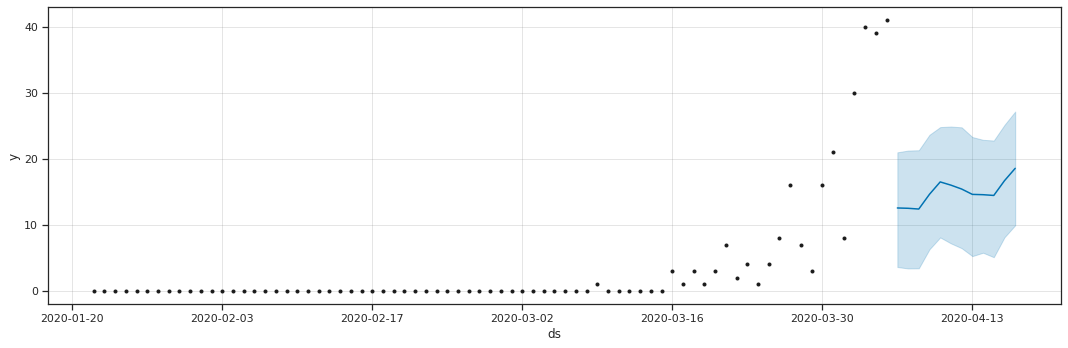

In [49]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_forcast,ax=ax)
plt.show()

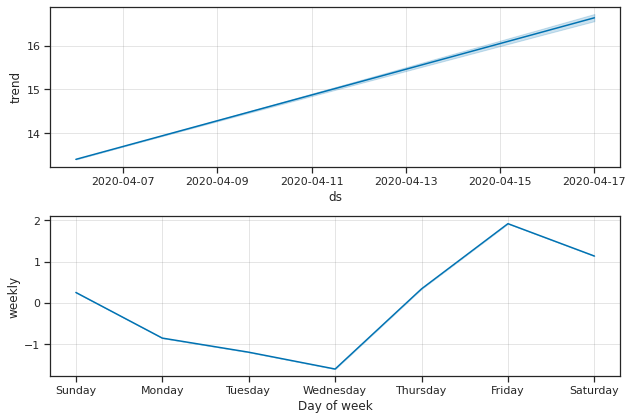

In [50]:
# Plot the components of the model
fig = model.plot_components(test_forcast)

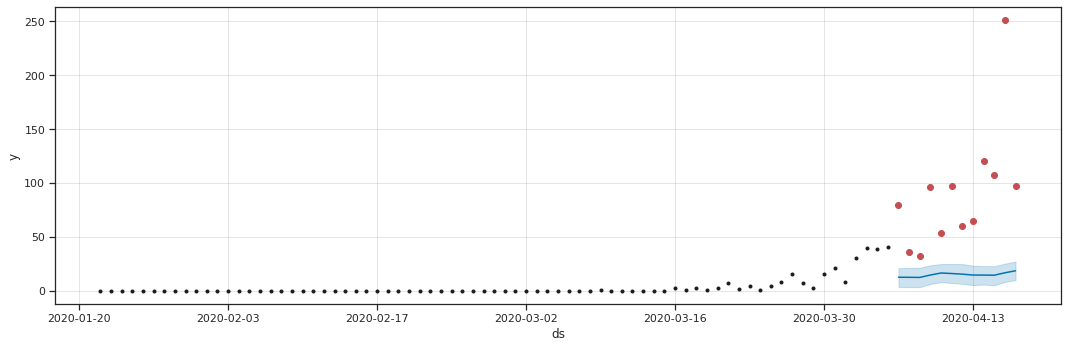

In [52]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Daily_death'], color='r')
fig = model.plot(test_forcast, ax=ax)